In [329]:
from constants import price_models
from standard_pricing_model import get_standard_cost
from timing_pricing_model import get_timing_price_model_cost
from utils import (
    load_data,
    get_tier
)
import pandas as pd
import matplotlib.pyplot as plt

In [330]:
def get_pricing_category(time, price_model):
    if not 'time_ranges' in price_model:
        return 'default'

    for category, time_ranges in price_model['time_ranges'].items():

        for range in time_ranges:
            start, end = range

            if time.hour >= start and time.hour < end:
                return category

In [331]:
def get_rate(row, price_model):
    return price_model['rate'][row['tier']][row['rate_category']]

In [332]:
def get_month_cost(month_group, price_model):
    month_group['cumulative_kwh'] = month_group['Consumption'].cumsum()
    month_group['tier'] = month_group['cumulative_kwh'].apply(get_tier)
    month_group['pricing_category'] = month_group['Start Time'].apply(lambda x: get_pricing_category(x, price_model))
    month_group['rate'] = month_group.apply(lambda row: get_rate(row, price_model), axis=1)
    month_group['daily_cost'] = month_group['rate'] * month_group['Consumption']


    return month_group['daily_cost'].sum()


In [333]:
def main():
    df = pd.read_csv('data.csv', skiprows=13, parse_dates=['Date', 'Start Time'])

    
    df['monthly_consumption'] = df['Consumption'].groupby(df.Date.dt.month).cumsum()
    df['tier'] = df['monthly_consumption'].apply(get_tier)
    
    price_model_groups = []

    for price_model in price_models:
      price_model_name = price_model['name']
      price_model_groups.append(f'{price_model_name}_daily_cost')
      df[f'{price_model["name"]}_rate_category'] = df.apply(lambda row: 
        get_pricing_category(row['Start Time'], price_model), 
        axis=1)

      df[f'{price_model["name"]}_rate'] = df.apply(lambda row:
        price_model['rate'][row['tier']][row[f'{price_model["name"]}_rate_category']],
        axis=1)

      df[f'{price_model["name"]}_daily_cost'] = df['Consumption'] * df[f'{price_model["name"]}_rate']

     # make one column with a tuple for each price model total

    month_group = df.groupby(df.Date.dt.month)
    

    for price_model in price_models:
      price_model_groups.append(f'')
    month_group = df.groupby(df.Date.dt.month)
    fig, axes = plt.subplots(111)

    for name, group in month_group:
      i = 0
      ax = axes.flat[i]

      for model in price_models:
        group[f'{model["name"]}_daily_cost'].sum().plot.bar(x='Date', y=f'{model["name"]}_daily_cost', ax=ax)
      
      i += 1

    # print(month_group)

    # for month in month_group['Date'].unique():
    #   month_group[month_group['Date'] == month]['standard_daily_cost'].plot(x='Date', y='standard_daily_cost')


    # for month, month_group in df.groupby(df.Date.dt.month):
    #     for price_model in pricing_models:
    #         cost = get_month_cost(month_group, price_model)

    #         print(f"{price_model['name']} cost: {cost}")

    


      


  

AttributeError: 'numpy.float64' object has no attribute 'plot'

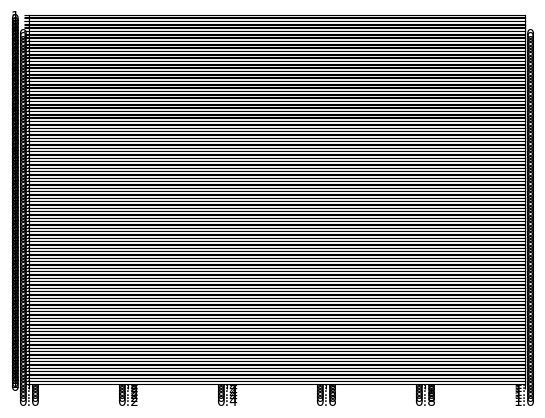

In [334]:
main()